In [8]:
import os
import urllib
import math
import requests
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import earthpy as et
import hydrofunctions as hf

# Date time conversion registration
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

# # Get the data & set working director
# data = et.data.get_data('colorado-flood')
# os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [2]:
# Define the site number and start and end# Define the site number and start and end dates that you are interested in
site = "06730500"
start = '1946-05-10'
end = '2018-08-29'

# Request data for that site and time period
longmont_resp = hf.get_nwis(site, 'dv', start, end)

# Convert the response to a json in order to use the extract_nwis_df function
longmont_resp = longmont_resp.json()

# Get metadata about the data
hf.get_nwis(site, 'dv').json() 

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06730500&startDT=1946-05-10&endDT=2018-08-29
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06730500


{'name': 'ns1:timeSeriesResponseType',
 'declaredType': 'org.cuahsi.waterml.TimeSeriesResponseType',
 'scope': 'javax.xml.bind.JAXBElement$GlobalScope',
 'value': {'queryInfo': {'queryURL': 'http://waterservices.usgs.gov/nwis/dv/format=json%2C1.1&sites=06730500',
   'criteria': {'locationParam': '[ALL:06730500]',
    'variableParam': 'ALL',
    'parameter': []},
   'note': [{'value': '[ALL:06730500]', 'title': 'filter:sites'},
    {'value': '[mode=LATEST, modifiedSince=null]',
     'title': 'filter:timeRange'},
    {'value': 'methodIds=[ALL]', 'title': 'filter:methodId'},
    {'value': '2021-09-02T20:44:08.983Z', 'title': 'requestDT'},
    {'value': '85861a70-0c2e-11ec-88d1-2cea7f5e5ede', 'title': 'requestId'},
    {'value': 'Provisional data are subject to revision. Go to http://waterdata.usgs.gov/nwis/help/?provisional for more information.',
     'title': 'disclaimer'},
    {'value': 'sdas01', 'title': 'server'}]},
  'timeSeries': [{'sourceInfo': {'siteName': 'BOULDER CREEK AT MOUTH

In [3]:
# Get the data in a pandas dataframe format
longmont_discharge_raw = hf.extract_nwis_df(longmont_resp)
longmont_discharge= pd.DataFrame(longmont_discharge_raw[0])


# Rename columns
longmont_discharge.columns = ["discharge", "flag"]

# Add a year column to your longmont discharge data
longmont_discharge["year"] = longmont_discharge.index.year

# Calculate annual max by resampling
longmont_discharge_annual_max = longmont_discharge.resample('AS').max()

# View first 5 rows
longmont_discharge_annual_max.head()

,discharge,flag,year
datetimeUTC,,,
1946-01-01 00:00:00+00:00,99.000000,A,1946
1947-01-01 00:00:00+00:00,1930.000000,A,1947
1948-01-01 00:00:00+00:00,339.000000,A,1948
1949-01-01 00:00:00+00:00,2010.000000,hf.missing,1949
1950-01-01 00:00:00+00:00,63.594991,hf.missing,1950


In [7]:


# Download usgs annual max data from figshare
url = "https://nwis.waterdata.usgs.gov/nwis/peak?site_no=06730500&agency_cd=USGS&format=rdb"

download_path = "/home/awstclair/github_forks/earth-analytics/data/colorado-flood/downloads/annual-peak-flow.txt"

# urllib.request.urlretrieve(url, download_path)

# A function that counts the number of lines with a comment 
def count_the(file_url):
    r = requests.get(file_url, stream=True)
    file = r.text
    count = 0
    for line in file:
        if line.startswith('#'):
            count += 1
    return count

# Lines to skip
line_to_skip = count_the(url)+1
print(line_to_skip)

# Open the data using pandas
usgs_annual_max = pd.read_csv(download_path,
                              comment="#",
                              sep='\t',
                              parse_dates=["peak_dt"],
                              skiprows=[73],
                              usecols=["peak_dt","peak_va"],
                              index_col="peak_dt")
usgs_annual_max.head()

# Add a year column to the data for easier plotting
usgs_annual_max["year"] = usgs_annual_max.index.year

# Remove duplicate years - keep the max discharge value
usgs_annual_max = usgs_annual_max.sort_values(
    'peak_va', ascending=False).drop_duplicates('year').sort_index()

# View cleaned dataframe
usgs_annual_max.head()

73


,peak_va,year
peak_dt,,
1927-07-29,407.0,1927
1928-06-04,694.0,1928
1929-07-23,530.0,1929
1930-08-18,353.0,1930
1931-05-29,369.0,1931


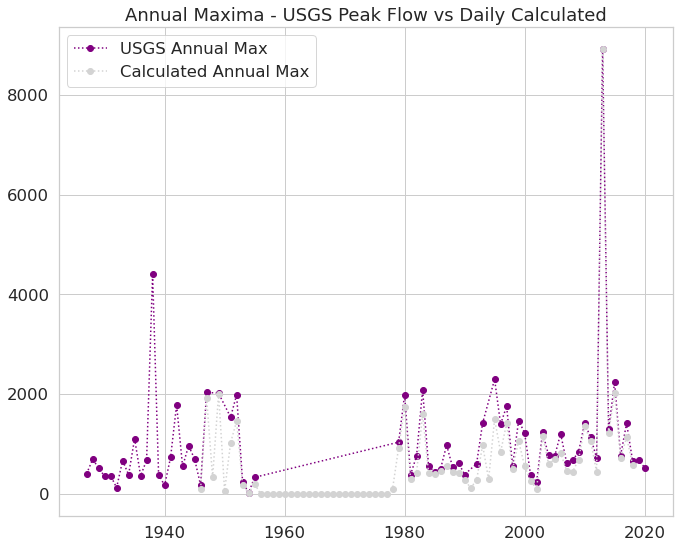

In [9]:
# Plot calculated vs USGS annual max flow values
fig, ax = plt.subplots(figsize = (11,9))

ax.plot(usgs_annual_max["year"], 
        usgs_annual_max["peak_va"],
        color = "purple",
        linestyle=':', 
        marker='o', 
        label = "USGS Annual Max")

ax.plot(longmont_discharge_annual_max["year"], 
        longmont_discharge_annual_max["discharge"],
        color = "lightgrey",
        linestyle=':', 
        marker='o', label = "Calculated Annual Max")

ax.legend()
ax.set_title("Annual Maxima - USGS Peak Flow vs Daily Calculated")

plt.show()

In [10]:
# Convert site drainage area to square km
miles_km = 2.58999
site_drainage = 447
longmont_area = site_drainage * miles_km

print("The site drainage area in square km =", longmont_area)

The site drainage area in square km = 1157.72553


In [11]:
convert_to_cub_feet_day = (60*60*24)

convert_to_runoff = convert_to_cub_feet_day*longmont_area
convert_to_runoff

100027485.792

In [12]:
# MAR - Mean Annual Runoff
longmont_discharge["cum-sum-vol"] = longmont_discharge[
    'discharge'].cumsum()*convert_to_runoff

longmont_discharge.head()

,discharge,flag,year,cum-sum-vol
datetimeUTC,,,,
1946-05-10 00:00:00+00:00,16.0,A,1946,1.600440e+09
1946-05-11 00:00:00+00:00,19.0,A,1946,3.500962e+09
1946-05-12 00:00:00+00:00,9.0,A,1946,4.401209e+09
1946-05-13 00:00:00+00:00,3.0,A,1946,4.701292e+09
1946-05-14 00:00:00+00:00,7.8,A,1946,5.481506e+09


In [13]:
# Plot your data
fig, ax = plt.subplots(figsize=(11,7))
longmont_discharge["cum-sum-vol"].plot(ax=ax, label = "Cumulative Volume")

# Make the y-axis label, ticks and tick labels match the line color.
ax.set_ylabel('Total Area Runoff', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()

ax2.scatter(x=longmont_discharge.index, 
        y=longmont_discharge["discharge"], 
        marker="o",
        s=4, 
        color ="purple", label="Daily Mean")

ax2.set_ylabel('Stream Discharge (CFS)', color='purple')
ax2.tick_params('y', colors='purple')
ax2.set_ylim(0,10000)

ax.set_title("Cumulative Sum & Daily Mean Discharge")
ax.legend()

# Reposition the second legend so it renders under the first legend item
ax2.legend(loc = "upper left", bbox_to_anchor=(0.0, 0.9))

fig.tight_layout()

plt.show()